# Setup and Module Imports

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import pandas as pd

# Import Data + Clean Data
def importCleanData(file_name, sheet, columns):
    data = pd.read_excel(file_name, sheet_name = sheet)
    cleanData = data.iloc[:, columns].dropna()
    return cleanData

def importCleanDataCSV(file_name, columns):
    data = pd.read_csv(file_name, header = None)
    cleanData = data.iloc[:, columns].dropna()
    return cleanData

justin = 'C:/Users/dhlpablo_m2/Desktop/Git/Data_extraction_kinetic_signaling_data/data/train_data/vegf_testdata'
Lionel = 'C:/Users/Imoukhuede lab/OneDrive - UW/Desktop/GitHub/Data_extraction_kinetic_signaling_data/data/train_data/vegf_testdata'
os.chdir(justin)


# Function Building

In [46]:
# Function 1: Baseline falling to steady state response
def baseline_steadystate_response(t, y_initial, y_final, kon):
    """
    Function to find the kon value from the data. 
    Assuming we know the baseline and the steady state response, we can find the kon value.
    The equation is y(t) = y_final * (1 - exp(-kon * t)) + y_intial

    Parameters
    ----------
    data : pandas dataframe
        Dataframe containing the time and response values
    y_intial : float
        The baseline value of the response
    y_final : float
        The steady state value of the response
    t : float
        The time value

    Returns
    -------
    function
        The function that can be used to calculate the response
    """
    return y_final * (1 - np.exp(-kon * t)) + y_initial

# Function 2: Response falling to zero
def response_to_zero(t, C, y_initial,  kon, koff):
    """
    Function to find the kon and koff values from the data
    Assuming we know that the response goes to zero

    Parameters
    ----------
    data : pandas dataframe
        Dataframe containing the time and response values
    C : float
        The initial rate of signaling
    y_initial : float
        The baseline value of the response
    t : float
        The time value
    
    Returns
    -------
    function
        The function that can be used to calculate the response

    """
    return (C / (kon - koff)) * (np.exp(-koff * t) - np.exp(-kon * t)) + y_initial

# Function 3: Response falling to steady state response
def response_to_steady_state(t, y_initial, y_final,  D, kon, koff):
    """
    Function to find the kon and koff values from the data
    Assuming we know the steady state response

    Parameters
    ----------
    data : pandas dataframe
        Dataframe containing thetime and response values
    y_initial : float
        The initial rate of signaling
    y_final : float
        The final rate of signaling
    t : float
        The time value
    
    Returns
    -------
    function
        The function that can be used to calculate the response

    """
    return y_final * ( 1 - D * np.exp(-kon * t) + (D - 1) * np.exp(-koff * t)) + y_initial

# Function 4: Typical association
def typical_association(t, y_final, conc, kon, koff):
    """
    Function to find the kon and koff values from the data
    Assuming it is a typical association function

    Parameters
    ----------
    data : pandas dataframe
        Dataframe containing thetime and response values
    y_final : float
        The final rate of signaling
    t : float
        The time value
    conc : float
        The concentration of the substance
    
    Returns
    -------
    function
        The function that can be used to calculate the response

    """
    kd = koff/kon
    return ( (y_final * conc) / (koff/kon + conc) ) * (1 - np.exp( (-1*(kon * conc + koff)) * t) )

# Function 5: Typical dissociation
def typical_dissociation(t, y_initial, koff):
    """
    Function to find the koff values from the data
    Assuming it is a typical dissociation function

    Parameters
    ----------
    data : pandas dataframe
        Dataframe containing thetime and response values
    y_initial : float
        The initial rate of signaling
    t : float
        The time value
    
    Returns
    -------
    function
        The function that can be used to calculate the response

    """
    return y_initial * np.exp(-koff * t)

def plot_data(fitted_response, time_pt, response_data, function, fitted_param, label):
    """
    This function plots the data and the fitted data on the same graph against time.

    Parameters
    ----------
    fitted_response : numpy array
        The fitted response values from the dissociation function
    time_pt : pandas Series
        The series containing the time values
    response_data : pandas Series
        The series containing the experimental response values
    function : function
        The function that was used to fit the data
    fitted_param : list
        The parameters of the function
    label : string
        The label of the data

    Returns
    -------
    None
    """
    
    plt.plot(time_pt, response_data, 'o', label=f'Experimental Data: {label}')

    
    fitted_values = function(time_pt, *fitted_param)
    plt.plot(time_pt, fitted_values, '-', label=f'Fitted Curve: {label}')

    plt.xlabel('Time (t)')
    plt.ylabel('Response')
    plt.title(f'Data and Fitted Curve for {label}')

    
    plt.legend()
    plt.show()

    
    print("Fitted parameters: ", fitted_param)

# Overall Function

In [84]:
# Function 6: Plotting the fitted curve
def plot_fitted_curve(assumption, data, param_k):
       
        if assumption == baseline_steadystate_response:
            plt.plot(data.iloc[:, 0], data.iloc[:, 1], 'o', label='Experimental Data')

            fitted_response = baseline_steadystate_response(data.iloc[:, 0], *param_k)

            plt.plot(data.iloc[:, 0], fitted_response, '-', label='Fitted Curve')

            plt.xlabel('Time (t)')
            plt.ylabel('Response')
            plt.title('Data and Fitted Curve')

            plt.legend()

            plt.show()

            print("Fitted parameters: ", param_k)

            time = data.iloc[:, 0]
            response = data.iloc[:, 1]

            # Fit the data
            p0 = [0.1, 0.9, 0.05]  # Adjust initial guess
            
            param_k, pcov_k = curve_fit(baseline_steadystate_response, time, response, p0=p0)

            # Generate smooth points for a better-looking plot
            t_fine = np.linspace(min(time), max(time), 100)
            fitted_response = baseline_steadystate_response(t_fine, *param_k)

            # Plot
            plt.plot(time, response, 'o', label='Experimental Data')
            plt.plot(t_fine, fitted_response, '-', label='Fitted Curve')
            plt.xlabel('Time (t)')
            plt.ylabel('Response')
            plt.title('Data and Fitted Curve')
            plt.legend()
            plt.show()

        elif assumption == response_to_zero:
            plt.plot(data.iloc[:, 0], data.iloc[:, 1], 'o', label='Experimental Data')

            fitted_response = response_to_zero(data.iloc[:, 0], *param_k)
            plt.plot(data.iloc[:, 0], fitted_response, '-', label='Fitted Curve')


            plt.xlabel('Time (t)')
            plt.ylabel('Response')
            plt.title('Data and Fitted Curve')

            plt.legend()

            plt.show()

            print("Fitted parameters: ", param_k)

        elif assumption == response_to_steady_state:
            plt.plot(data.iloc[:, 0], data.iloc[:, 1], 'o', label='Experimental Data')

            fitted_response = response_to_steady_state(data.iloc[:, 0], *param_k)
            plt.plot(data.iloc[:, 0], fitted_response, '-', label='Fitted Curve')

            plt.xlabel('Time (t)')
            plt.ylabel('Response')
            plt.title('Data and Fitted Curve')

            plt.legend()

            plt.show()

            print("Fitted parameters: ", param_k)

            time = data.iloc[:, 0]
            response = data.iloc[:, 1]

            # Fit the data
            p0 = [0, 1, 1, 0.1, 0.1]  # Adjust initial guess
            
            param_k, pcov_k = curve_fit(response_to_steady_state, time, response, p0=p0)

            # Generate smooth points for a better-looking plot
            t_fine = np.linspace(min(time), max(time), 100)
            fitted_response = response_to_steady_state(t_fine, *param_k)

            # Plot
            plt.plot(time, response, 'o', label='Experimental Data')
            plt.plot(t_fine, fitted_response, '-', label='Fitted Curve')
            plt.xlabel('Time (t)')
            plt.ylabel('Response')
            plt.title('Data and Fitted Curve')
            plt.legend()
            plt.show()
    
        elif assumption == typical_association:
            plt.plot(data.iloc[:, 0], data.iloc[:, 1], 'o', label='Experimental Data')

            fitted_response = typical_association(data.iloc[:, 0], *param_k)
            plt.plot(data.iloc[:, 0], fitted_response, '-', label='Fitted Curve')


            plt.xlabel('Time (t)')
            plt.ylabel('Response')
            plt.title('Data and Fitted Curve')

            plt.legend()

            plt.show()

            print("Fitted parameters: ", param_k)

        elif assumption == typical_dissociation:
            plt.plot(data.iloc[:, 0], data.iloc[:, 1], 'o', label='Experimental Data')

            fitted_response = typical_dissociation(data.iloc[:, 0], *param_k)
            plt.plot(data.iloc[:, 0], fitted_response, '-', label='Fitted Curve')


            plt.xlabel('Time (t)')
            plt.ylabel('Response')
            plt.title('Data and Fitted Curve')

            plt.legend()

            plt.show()

            print("Fitted parameters: ", param_k)


    # Fitting the data to its appropriate function
def fit_data(time, response, p0, assumption, data):
    """
    Function to fit the data to the function

    Parameters
    ----------
    time : pandas Series
        The series containing the time values
    response : pandas Series
        The series containing the response values
    p0 : list
        The initial guess of the parameters
    assumption : string
        The assumption of the function
    data : pandas dataframe
        The dataframe containing the test data

    Returns
    -------
    param_k
        The parameters of the function
    pcov_k  
        The covariance of the parameters
    """
 
    if assumption == "baseline+steadystate":
        def baseline_steadystate_response(t, y_initial, y_final, kon):
            """
            Function to find the kon value from the data. 
            Assuming we know the baseline and the steady state response, we can find the kon value.
            The equation is y(t) = y_final * (1 - exp(-kon * t)) + y_intial

            Parameters
            ----------
            data : pandas dataframe
                Dataframe containing the time and response values
            y_intial : float
                The baseline value of the response
            y_final : float
                The steady state value of the response
            t : float
                The time value

            Returns
            -------
            function
                The function that can be used to calculate the response
            """
            return y_final * (1 - np.exp(-kon * t)) + y_initial
        function = baseline_steadystate_response
        param_k, pcov_k = curve_fit(function, time, response, p0 = p0)
        plot_fitted_curve(function, data, param_k)

    elif assumption == "response to zero":
        def response_to_zero(t, C, y_initial, kon, koff):
            """
            Function to find the kon and koff values from the data
            Assuming we know that the response goes to zero

            Parameters
            ----------
            data : pandas dataframe
                Dataframe containing the time and response values
            C : float
                The initial rate of signaling
            y_initial : float
                The baseline value of the response
            t : float
                The time value
            
            Returns
            -------
            function
                The function that can be used to calculate the response

            """
            return (C / (kon - koff)) * (np.exp(-koff * t) - np.exp(-kon * t)) +y_initial
        
        function = response_to_zero
        param_k, pcov_k = curve_fit(function, time, response, p0 = p0)
        plot_fitted_curve(function, data, param_k)  

    elif assumption == "response to steady state":
        def response_to_steady_state(t, y_initial, y_final, D, kon, koff):
            """
            Function to find the kon and koff values from the data
            Assuming we know the steady state response

            Parameters
            ----------
            data : pandas dataframe
                Dataframe containing thetime and response values
            y_initial : float
                The initial rate of signaling
            y_final : float
                The final rate of signaling
            t : float
                The time value
            
            Returns
            -------
            function
                The function that can be used to calculate the response

            """
            return y_final * ((1 - D * np.exp(-kon * t)) + (D - 1) * np.exp(-koff * t)) + y_initial
        
        function = response_to_steady_state
        param_k, pcov_k = curve_fit(function, time, response, p0 = p0)
        plot_fitted_curve(function, data, param_k)

    elif assumption == "typical_association":
        def typical_association(t, y_final, conc, kon, koff):
            """
            Function to find the kon and koff values from the data
            Assuming it is a typical association function

            Parameters
            ----------
            data : pandas dataframe
                Dataframe containing thetime and response values
            y_final : float
                The final rate of signaling
            t : float
                The time value
            conc : float
                The concentration of the substance
    
            Returns
            -------
            function
                The function that can be used to calculate the response

            """
            kd = koff/kon
            return ( (y_final * conc) / (koff/kon + conc) ) * (1 - np.exp( (-1*(kon * conc + koff)) * t) )
        function = typical_association
        param_k, pcov_k = curve_fit(function, time, response, p0 = p0)
        plot_fitted_curve(function, data, param_k)


    elif assumption == "typical_dissociation":
        def typical_dissociation(t, y_initial, koff):
            """
            Function to find the koff values from the data
            Assuming it is a typical dissociation function

            Parameters
            ----------
            data : pandas dataframe
                Dataframe containing thetime and response values
            y_initial : float
                The initial rate of signaling
            t : float
                The time value
    
            Returns
            -------
            function
                The function that can be used to calculate the response

            """
            return y_initial * np.exp(-koff * t)
        function = typical_dissociation
        param_k, pcov_k = curve_fit(function, time, response, p0 = p0)
        plot_fitted_curve(function, data, param_k)
    plot_fitted_curve(function, data, param_k)
    return param_k, pcov_k

# Test Cases

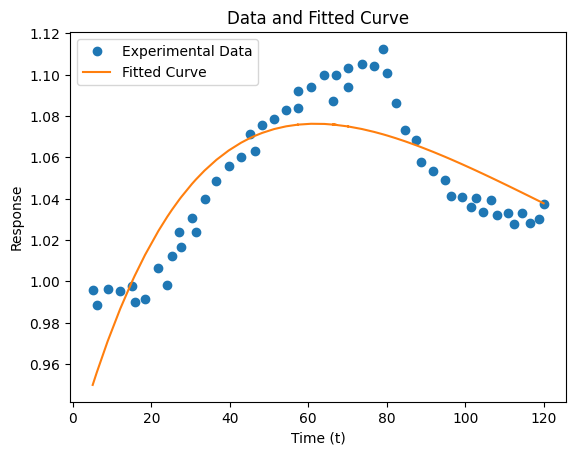

Fitted parameters:  [0.00698435 0.9174379  0.01616845 0.01617234]


In [71]:
#importCleanDataCSV("B_arrestin_binding_to_B2_4A.csv", [0,1])
data = importCleanData("B_arrestin_binding_to_the_B2_4A.xlsx", "Sheet1", [0,1])

param_k, pcov_k = fit_data(data.iloc[:, 0], data.iloc[:, 1], p0 = [0.002, 1, 0.1, 0.02], assumption = "response to zero", data = data)
plot_fitted_curve(response_to_zero, data, param_k)


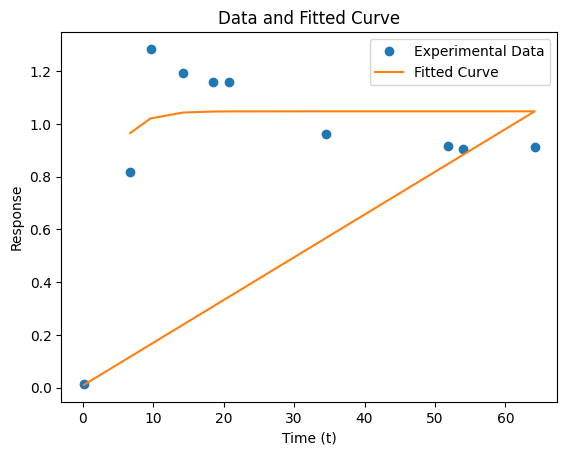

Fitted parameters:  [-0.05423414  1.10239183  0.38491531]


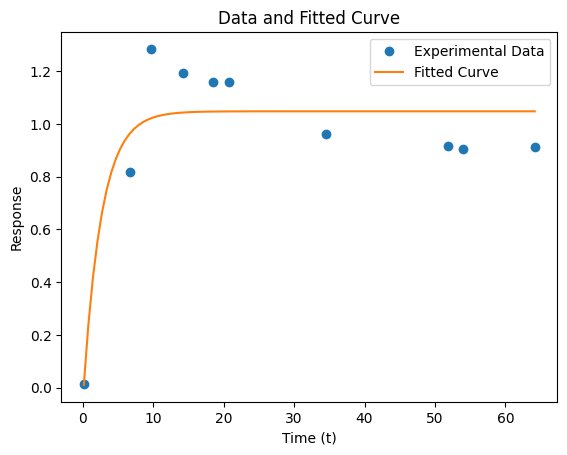

In [69]:
data = importCleanData("Daly_2023_Fig_3B_data.xlsx", "Sheet1", [0,1])

param_k, pcov_k = fit_data(data.iloc[:, 0], data.iloc[:, 1], p0 = [0.1, 0.9, 0.05], assumption = "baseline+steadystate", data = data)
plot_fitted_curve(baseline_steadystate_response, data, param_k)


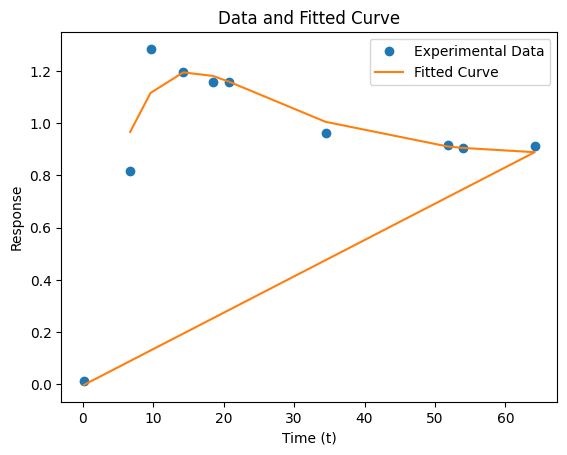

Fitted parameters:  [-4.25536684e-02  9.20161928e-01 -2.60214021e+02  1.04285103e-01
  1.04966427e-01]


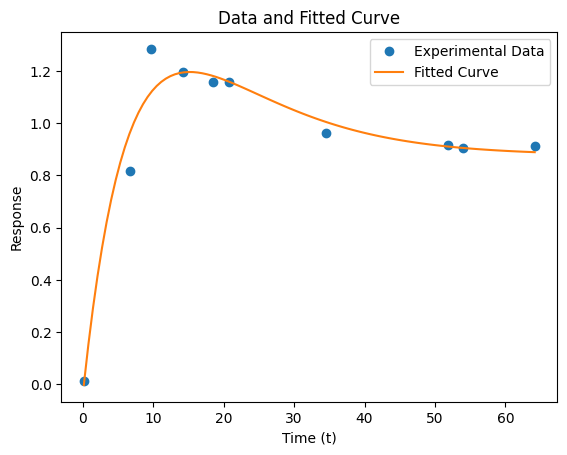

In [85]:
data = importCleanData("Daly_2023_Fig_3B_data.xlsx", "Sheet1", [0,1])

param_k, pcov_k = fit_data(data.iloc[:, 0], data.iloc[:, 1], p0 = [0, 1, 1, 0.1, 0.1], assumption = "response to steady state", data = data)
plot_fitted_curve(response_to_steady_state, data, param_k)

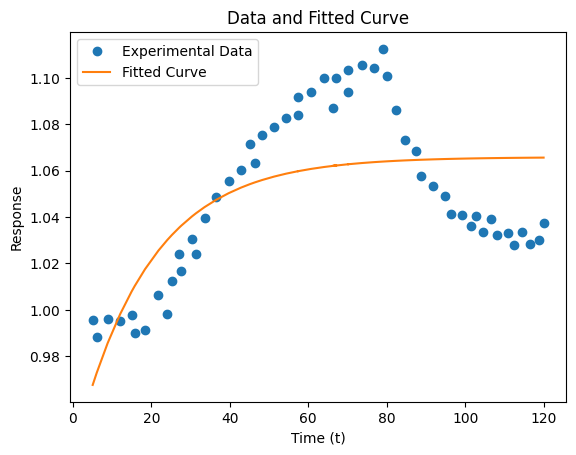

Fitted parameters:  [-0.01487686  1.08073844  0.11894768  0.0531763   3.10489407]


In [73]:
data = importCleanData("B_arrestin_binding_to_the_B2_4A.xlsx", "Sheet1", [0,1])

param_k, pcov_k = fit_data(data.iloc[:, 0], data.iloc[:, 1], p0 = [0, 1.1, 0.1, 0.1, 0.5], assumption = "response to steady state", data = data)
plot_fitted_curve(response_to_steady_state, data, param_k)


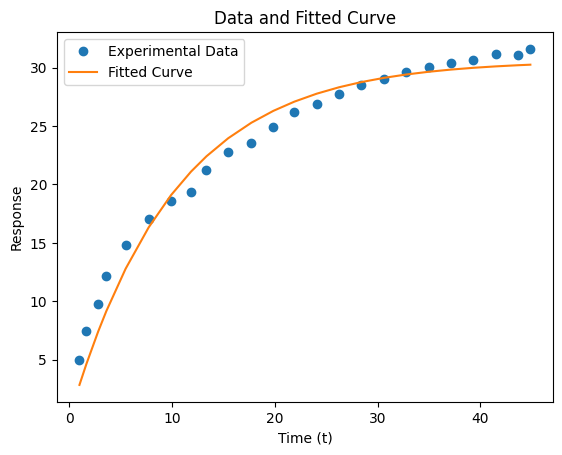

Fitted parameters:  [3.80787871e+01 2.68612766e-01 2.95180211e-01 1.93488212e-02]


In [74]:
data = importCleanData("Horing_2020_Fig1B_H1R_data.xlsx", "Sheet1", [0,1])

param_k, pcov_k = fit_data(data.iloc[:, 0], data.iloc[:, 1], p0 = [30, 1, 1, 1], assumption = "typical_association", data = data)
plot_fitted_curve(typical_association, data, param_k)

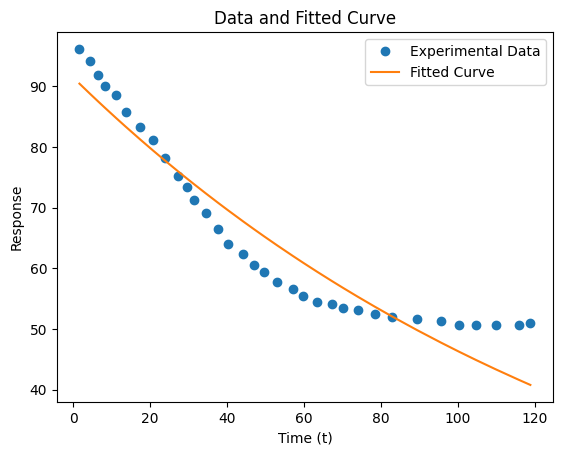

Fitted parameters:  [9.14541221e+01 6.78952483e-03]


In [75]:
data = importCleanData("Hilger_2021_Fig_S9A_Beta2AR_data.xlsx", "Sheet1", [0,1])

param_k, pcov_k = fit_data(data.iloc[:, 0], data.iloc[:, 1], p0 = [95, 0.01], assumption = "typical_dissociation", data = data)
plot_fitted_curve(typical_dissociation, data, param_k)